
# AerialWatch — Reproducible Model Notebook
**Author:** Margarita Rincon Matamoros  
This notebook reconstructs the MobileNetV2 architecture and loads the final trained weights.  
It provides a lightweight, reproducible way to run the trained model on the prepared dataset.
No training occurs here — the goal is fast reproduction.


**MobileNetV2 Approach**

 We used a pretrained MobileNetV2 model and fine-tuned it for binary classification (people vs. no-people). Unlike our custom CNN, MobileNetV2 provides deeper feature representations from prior ImageNet training, enabling better generalization on limited drone data.

**Project**

Aerial Watch is a computer vision model capable of determining whether an aerial drone image contains people or no people.

The goal is to create an efficient classifier suitable for real-time or near real-time applications, such as search-and-rescue drones, surveillance systems, and autonomous monitoring.

**GOAL**

Use supervised machine learning to classify drone images into two categories:

*   People
*   No_people

The model learns to recognize humans from above — even when people appear extremely small, partially occluded, or blended into complex outdoor environments.

**Dataset: SARD - Search And Rescue Dataset:   Object Detection**

Dataset From: **https://universe.roboflow.com/datasets-pdabr/sard-8xjhy**

This dataset contains multi-modal (Image / Labels) information collected from real-world images, taken by drone. It is designed to support the development and evaluation of AI models for locating, identifying, and tracking individuals in distress during disaster or emergency scenarios.

To develop the SARD dataset, the authors involved actors, who simulated exhausted and injured people and classic types of movement. The images were recorded by high resolution camera with DJI Phantom 4A Drone.


Authors suggested approach to this dataset is YOLO (You Only Look Once) models, especially v5 or v8 for detection.

Publication Date: 2025, 2 May

Classes: Human


**Data Format**

The dataset includes 5755 images.
Person are annotated in YOLOv8 format.



**Images: Train 4k, Test 0.5k, Valid 1.1k**

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

In [ ]:
# Imports
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec

# packages for PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, random_split, Dataset, DataLoader, TensorDataset
import torchvision.models as models
torch.manual_seed(18);

In [ ]:
# For this project CUDA is recommended
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


**Prep Files**

In previous notebooks I had an extra step to separate files into People / No people according to the file annotation.

Here, we are reading directly from the folder that's been prepared. So no need for that.

**Prep Data for model Training**


*   Normalize images. Because MobileNetV2 was trained on ImageNet Data, we need to use those values for normalization. Otherwise this is inneficient.
*   Image Augmentations. This would help improve model's generalization capabilities.

In [ ]:

IMG_SIZE = 224 #640x640 Original Dataset

#Param for Normalize - ImageNet
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]


#Original Basic Image Transformations
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# IMPORTANT:
base = "./classification_dataset"   #  - - - - - - > PATH TO READ THE FOLDER inside repo "Classification_dataset"

train_dir = f"{base}/train_output"
val_dir   = f"{base}/val_output"
test_dir  = f"{base}/test_output"


#Full Data for Training
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tfms)


#DataLoader. Load a small subset or Full Data
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

class_names = train_ds.classes
print("Train Classes:",class_names)

class_names = val_ds.classes
print("Val Classes:",class_names)

class_names = test_ds.classes
print("Test Classes:",class_names)


Train Classes: ['no_people', 'people']
Val Classes: ['no_people', 'people']
Test Classes: ['no_people', 'people']


### Dataset Path (Reproducible)
This notebook assumes that the folder **classification_dataset/** is located in the same directory as this notebook.  
It contains already-preprocessed splits:

- `train_output/people`, `train_output/no_people`
- `val_output/people`, `val_output/no_people`
- `test_output/people`, `test_output/no_people`

Because we use **relative paths**, the notebook runs correctly on any machine once the repository is cloned.


**Training the Model**

We'll be loading the weights saved from previous training.

**Construct the Model**

We are using a V2 Model for this problem. The expectation is that this will perform better than a CNN created from scratch.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Number of output classes
N_CLASSES = 2

# -----------------------------
# Rebuild the MobileNetV2 Model
# -----------------------------
mobilenet = models.mobilenet_v2(
    weights=models.MobileNet_V2_Weights.IMAGENET1K_V1
)


# Replacing classifier head (same as in training notebook)
mobilenet.classifier[1] = nn.Linear(1280, N_CLASSES)

# Move model to device
model = mobilenet.to(device)

# -----------------------------
# Load Saved Weights
# -----------------------------

# Path to saved weights inside repo
weights_path = "./models/mobilenet_final.pth"

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()   # Set to evaluation mode

print("Model loaded successfully from:", weights_path)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 216MB/s]


Epoch 1/20 - Train Loss: 0.3173, Train Correct: 3546/4041 - Test Loss: 0.2441, Test Correct: 522/570 Test Accuracy: 522/570 (91.58%)
Epoch 2/20 - Train Loss: 0.2240, Train Correct: 3668/4041 - Test Loss: 0.2713, Test Correct: 506/570 Test Accuracy: 506/570 (88.77%)
Epoch 3/20 - Train Loss: 0.2074, Train Correct: 3663/4041 - Test Loss: 0.2259, Test Correct: 515/570 Test Accuracy: 515/570 (90.35%)
Epoch 4/20 - Train Loss: 0.1937, Train Correct: 3723/4041 - Test Loss: 0.1473, Test Correct: 539/570 Test Accuracy: 539/570 (94.56%)
Epoch 5/20 - Train Loss: 0.1689, Train Correct: 3759/4041 - Test Loss: 0.1496, Test Correct: 539/570 Test Accuracy: 539/570 (94.56%)
Epoch 6/20 - Train Loss: 0.1617, Train Correct: 3776/4041 - Test Loss: 0.1777, Test Correct: 522/570 Test Accuracy: 522/570 (91.58%)
Epoch 7/20 - Train Loss: 0.1562, Train Correct: 3774/4041 - Test Loss: 0.1422, Test Correct: 534/570 Test Accuracy: 534/570 (93.68%)
Epoch 8/20 - Train Loss: 0.1539, Train Correct: 3784/4041 - Test Loss

**Asses Model Performance**

In [ ]:
print("Train classes:", train_ds.classes)
print("Test classes:",  test_ds.classes)

print("Train size:", len(train_ds))
print("Test size:",  len(test_ds))

Train classes: ['no_people', 'people']
Test classes: ['no_people', 'people']
Train size: 4041
Test size: 570


# Evaluation


In [ ]:
import torch.nn.functional as F

model.eval()
images, labels = next(iter(test_loader))

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

print("Predictions:", preds[:10].cpu().numpy())
print("Labels:     ", labels[:10].cpu().numpy())


In [ ]:
# Accuracy
correct = (preds == labels).sum().item()
total = labels.size(0)
print(f"Batch accuracy: {correct}/{total}")


Peek Into Classifications:

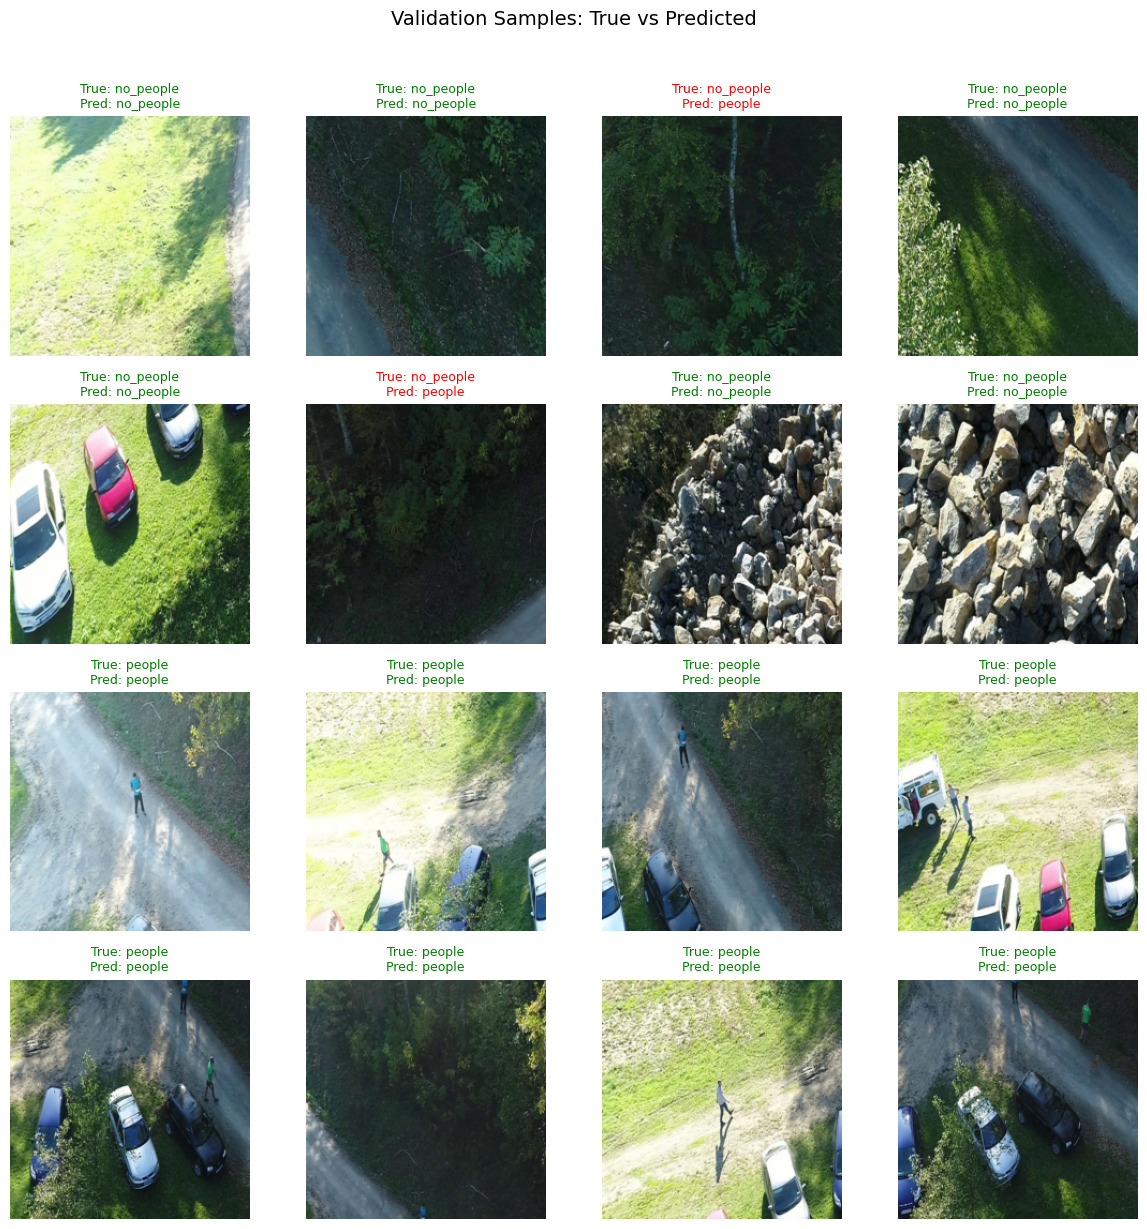

In [ ]:
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

# --- Config ---
K = 8  # images per class to show
classes = class_names       # assume len(classes) == 2
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

rows, cols = 4, 4  # 4x4 grid = 16 images total

# De-normalize a single image
def denorm_img(img_t):
    img = img_t.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * std) + mean
    return np.clip(img, 0, 1)

model.eval()

fig = plt.figure(figsize=(3*cols, 3*rows))
gs = gridspec.GridSpec(rows, cols, figure=fig)

# how many we've shown per class (0 and 1)
shown = {0: 0, 1: 0}
total_needed = K * 2  # 16
colormap = {True: "green", False: "red"}

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            true_c = labels[i].item()
            if true_c not in shown:
                continue  # just in case, but should be 0 or 1

            if shown[true_c] >= K:
                continue  # already have enough for this class

            # Compute position in the 4x4 grid
            # First 8 (indices 0–7) are class 0, next 8 (8–15) are class 1
            if true_c == 0:
                idx = shown[0]                    # 0..7
            else:
                idx = K + shown[1]                # 8..15

            row, col = divmod(idx, cols)
            ax = fig.add_subplot(gs[row, col])

            ax.imshow(denorm_img(images[i]))
            ax.axis('off')

            correct = (preds[i].item() == true_c)
            title = f"True: {classes[true_c]}\nPred: {classes[preds[i].item()]}"
            ax.set_title(title, color=colormap[correct], fontsize=9)

            shown[true_c] += 1
            total_needed -= 1

            if total_needed == 0:
                break
        if total_needed == 0:
            break

plt.suptitle("Validation Samples: True vs Predicted", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()
